# Olymploration: Who wins the most medals at the Olympics?

Rooted in rich history, symbolism and values associated with the Olympic games, Olympic medals are considered highly prestigious, often representing the pinnacle of athletic achievement. Winning an Olympic medal is a recognition of excellence on the international stage, and it often holds cultural and national significance. It is an opportunity for athletes from all nations, big or small, to transcend national boundaries and compete together. This tradition began in 1896 in Athens, Greece and with the exception of the games not being held due to the two world wars, the Summer games have been held every 4 years. The first Winter Olympics were held in Chamonix, France, in 1924. The goal of this project is to predict which country will win the most medals at the Olympic games. 

In [263]:
#import packages needed

import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import glob2 as glob
import missingno as msno
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing 

In [367]:
#read in files
relative_path = "data/raw/*.csv" 
file_list = glob.glob(relative_path)

dataframes = []


if not file_list:
    print("No CSV files found in the specified path.")
else:
    file_list.sort() #to stop the order from changing

    # Loop through the sorted file list and read each CSV file into a df
    for file in file_list:
        try:
            df = pd.read_csv(file)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")

In [368]:
 #name the dfs
df_athletes = dataframes[0]
df_event_results = dataframes[1]
df_medals = dataframes[2]
df_results = dataframes[3]
df_country = dataframes[4]
df_games = dataframes[5]
df_gdp_mean = dataframes[6]
df_pop_mean = dataframes[7]

In [369]:
dataframes = {'df_athletes': df_athletes, 
       'df_country': df_country, 
       'df_event_results': df_event_results, 
       'df_games': df_games, 
       'df_medals': df_medals, 
       'df_results': df_results,
             'df_gdp_mean' : df_gdp_mean,
             'df_pop_mean' : df_pop_mean}

In [267]:
#check missing values
def check_missing_values(df):
    return df.isnull().sum()


# check_missing_values(df_event_results)
# check_missing_values(df_country)
# check_missing_values(df_games)
# check_missing_values(df_athletes)
# check_missing_values(df_medals)
# check_missing_values(df_results)

def count_na(df):
    def helper(val):
        return val == 'na'
    return df.applymap(helper).sum() / df.shape[0]

# for key, value in dataframes.items():
#     print(f'\n\n{key}\n\n')
#     print(count_na(value))

In [268]:
# do we have winter olympics available as much? 
dict(Counter([i[5:] for i in df_games['edition'].unique()]))

{'Summer Olympics': 35,
 'Winter Olympics': 27,
 'Equestrian': 1,
 'Intercalated': 1}

In [269]:
df_games[df_games['end_date'].isna()]

#missing values for end_Date, start_date if the games were not held,
#isHeld is NA if the games took place which. These missing values will not affect our analysis

,edition,edition_id,edition_url,year,city,country_flag_url,country_noc,start_date,end_date,competition_date,isHeld
1,1900 Summer Olympics,2,/editions/2,1900,Paris,/images/flags/FRA.png,FRA,NaN,NaN,14 May – 28 October,NaN
2,1904 Summer Olympics,3,/editions/3,1904,St. Louis,/images/flags/USA.png,USA,14 May,NaN,1 July – 26 November,NaN
3,1908 Summer Olympics,5,/editions/5,1908,London,/images/flags/GBR.png,GBR,13 July,NaN,27 April – 31 October,NaN
5,1916 Summer Olympics,50,/editions/50,1916,Berlin,/images/flags/GER.png,GER,NaN,NaN,—,Not held due to war
11,1940 Summer Olympics,51,/editions/51,1940,Helsinki,/images/flags/FIN.png,FIN,NaN,NaN,—,Not held due to war
12,1944 Summer Olympics,52,/editions/52,1944,London,/images/flags/GBR.png,GBR,NaN,NaN,—,Not held due to war
32,2024 Summer Olympics,63,/editions/63,2024,Paris,/images/flags/FRA.png,FRA,NaN,NaN,—,NaN
33,2028 Summer Olympics,64,/editions/64,2028,Los Angeles,/images/flags/USA.png,USA,NaN,NaN,—,NaN
34,2032 Summer Olympics,372,/editions/372,2032,Brisbane,/images/flags/AUS.png,AUS,NaN,NaN,—,NaN
39,1940 Winter Olympics,55,/editions/55,1940,Garmisch-Partenkirchen,/images/flags/GER.png,GER,NaN,NaN,—,Not held due to war


In [270]:
# how many athletes take part by country
df_event_results.groupby(['edition', 'country_noc'], as_index=False)['athlete'].count().head()

,edition,country_noc,athlete
0,1896 Summer Olympics,AUS,7
1,1896 Summer Olympics,AUT,10
2,1896 Summer Olympics,BUL,4
3,1896 Summer Olympics,DEN,25
4,1896 Summer Olympics,FRA,51


In [271]:
# one athlete can take part in several events
df_event_results.groupby(['edition', 'country_noc'])['athlete'].unique().reset_index(name='unique_athletes').assign(athlete_count=lambda x: x['unique_athletes'].apply(len)).head()


,edition,country_noc,unique_athletes,athlete_count
0,1896 Summer Olympics,AUS,"[Teddy Flack, George Stuart Robertson]",2
1,1896 Summer Olympics,AUT,"[Adolf Schmal, Otto Herschmann, Paul Neumann]",3
2,1896 Summer Olympics,BUL,[Charles Champaud],1
3,1896 Summer Olympics,DEN,"[Viggo Jensen, Eugen Schmidt, Holger Nielsen, ...",4
4,1896 Summer Olympics,FRA,"[Adolphe Grisel, Jean Tournois, Louis Adler, A...",18


In [ ]:
# are the dates reasonable? 
#pd.to_datetime(df_games['year'], format='%Y').dt.year.sort_values(ascending=False)

In [ ]:
# inconsistencies between competition_date and start_date/end_date 
#df_games[['start_date', 'end_date', 'competition_date', 'isHeld']]

In [272]:
#total medals 

df_medals_agg = df_medals.groupby('country')[['gold', 'silver', 'bronze', 'total']].sum()
df_medals_agg.describe()

,gold,silver,bronze,total
count,154.000000,154.000000,154.000000,154.000000
mean,43.837662,43.668831,46.590909,134.097403
std,121.137176,105.514430,100.827272,325.596482
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,3.000000
50%,3.000000,4.500000,6.000000,13.000000
75%,26.750000,33.500000,36.000000,98.500000
max,1194.000000,970.000000,845.000000,3009.000000


Historically, USA, the Soviet Union, Germany, Great Britain and France have won the most medals at the Olympics.The Soviet Union won the second most at 1204 followed by Germany at 1098. In terms of gold and silver medals won, USA leads by a mile.  USA should be considered an outlier while modeling.  The table above shows the descriptive statistics for the medals data. As you can see, the lower 75% of countries have historically won a total of only 98 medals which confirms that only a handful of countries dominate at the games.

<strong><i>Who has won the most medals? </i> </strong>

In [273]:
#historically, who won the most medals?? 

df_medals2 = df_medals.groupby('country_noc')[['total','gold', 'silver', 'bronze']].sum()
df_medals2.reset_index(inplace=True)


top5_rows = df_medals2.nlargest(5, 'total')

top5_countries = top5_rows['country_noc'].tolist()
top5_medals = top5_rows['total'].tolist()

print(f"The top 5 countries are: {top5_countries}")
print(f"The corresponding counts are: {top5_medals}")

The top 5 countries are: ['USA', 'URS', 'GER', 'GBR', 'FRA']
The corresponding counts are: [3009, 1204, 1098, 989, 950]


In [274]:
# Melt the DataFrame to long format 
top_50 = df_medals2.nlargest(50, 'total')
df_medals3 = top_50.drop(['total'], axis=1)
df_medals_melted = pd.melt(df_medals3, id_vars='country_noc', var_name='Medal', value_name='Count')

df_medals_melted.head()

,country_noc,Medal,Count
0,USA,gold,1194
1,URS,gold,473
2,GER,gold,355
3,GBR,gold,312
4,FRA,gold,287


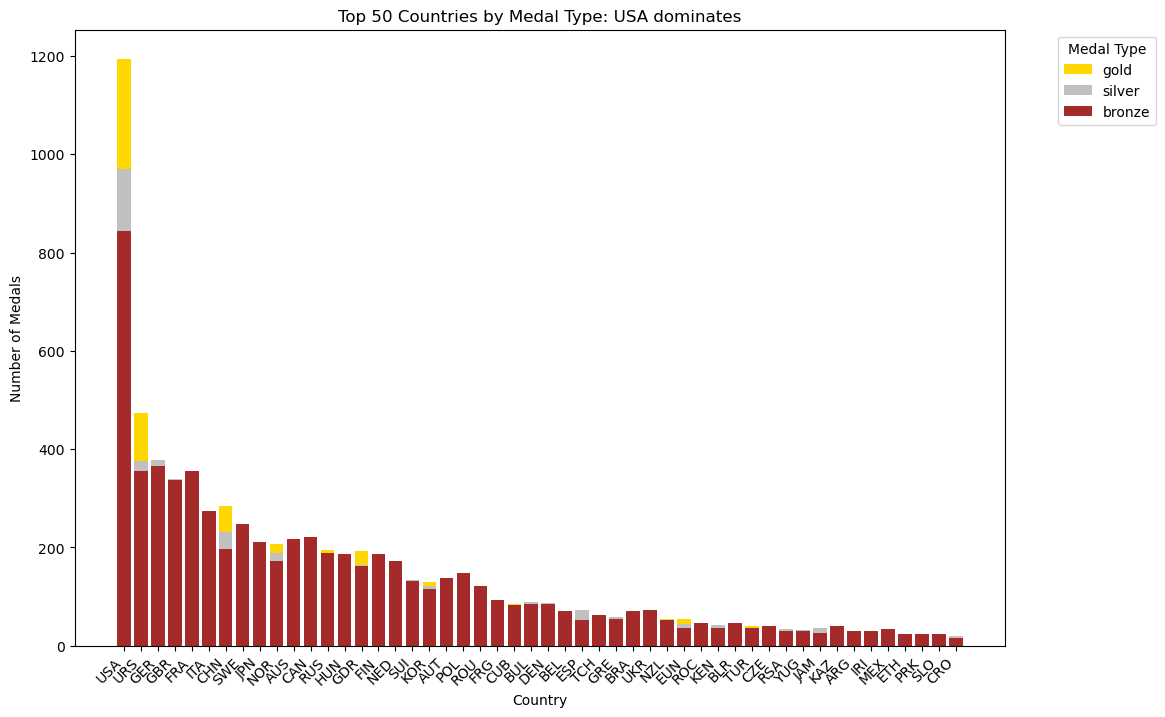

In [275]:
#who won the most medals

df_stacked = df_medals_melted.pivot_table(index='country_noc', columns='Medal', values='Count', fill_value=0)

df_stacked_sorted = df_stacked.sum(axis=1).sort_values(ascending=False).index
df_stacked = df_stacked.loc[df_stacked_sorted]


colors = {'gold': 'gold', 'silver': 'silver', 'bronze': 'brown'}

plt.figure(figsize=(12, 8))
for medal_type, color in colors.items():
    plt.bar(df_stacked.index, df_stacked[medal_type], color=color, label=medal_type)

plt.title('Top 50 Countries by Medal Type: USA dominates')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.legend(title='Medal Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right') 
plt.show()

<strong><i> Has anything changed in the past 20 years?</i></strong>

In [276]:
#has anything changed in the past 20 years?

#filter df to include 2004 Athens games onwards

df_last20 = df_medals[['year', 'country', 'total']].copy()

df_last20 = df_last20.loc[df_last20['year'] >= 1992]
df_last20.head()

,year,country,total
694,1992,Unified Team,112
695,1992,United States,108
696,1992,Germany,82
697,1992,People's Republic of China,54
698,1992,Cuba,31


In [277]:
total_by_country = df_last20.groupby('country')['total'].sum()
top_10_countries = total_by_country.sort_values(ascending=False).head(12)
top_10_countries_list = total_by_country.sort_values(ascending=False).head(12).index.tolist()

recent_games  = df_last20[df_last20['country'].isin(top_10_countries_list)]

recent_games.head()

,year,country,total
695,1992,United States,108
696,1992,Germany,82
697,1992,People's Republic of China,54
700,1992,Republic of Korea,29
702,1992,France,29


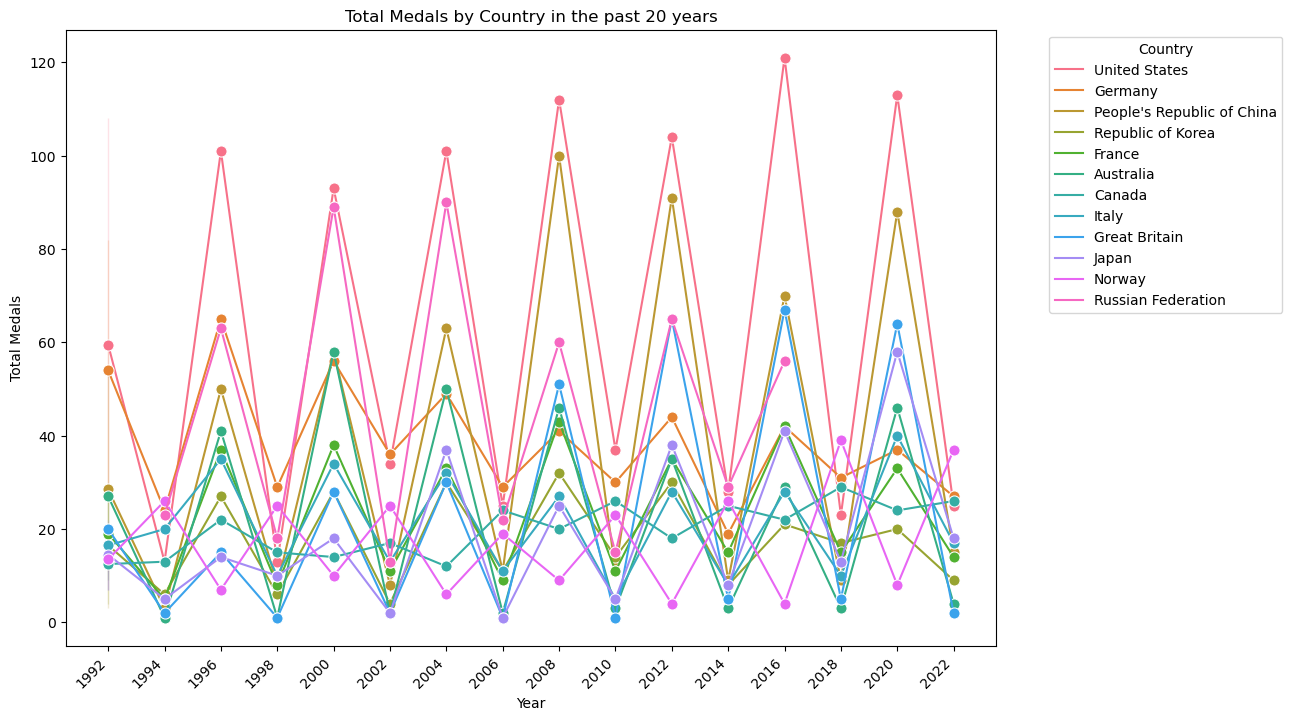

In [108]:

plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='total', hue='country', data=recent_games, marker='o', markersize=8)

plt.xticks(recent_games['year'].unique())

plt.title('Total Medals by Country in the past 20 years')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.xticks(rotation=45, ha='right')  
plt.show()

In the past 30 years, USA continues to remain extremely dominant at the Summer Olympics (first Summer Olympics in the graph took place in 1992 and first Winter Olympics took place in 1994). The Russian Federation/Soviet Union which historically had the second most medals is not as dominant as before. In the past 4 editions of the Summer games, China has won the second most number of medals, bypassing Russia. Great Britain has also steadily increased their medal count in the past 30 years.
However at the Winter Olympics, Norway's athletes have been outpacing the U.S. and Germany.


<strong> <i>Do GDP and Population have an impact on the number of medals won?<i><strong>

In [339]:
#GDP and population - using the past 10 year avg as a proxy as data is available 1960 onwards for some countries,
#while data for some is available even later
df_country_gdp = pd.read_csv('data/raw/country_gdp.csv')
df_country_gdp.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.727933e+09,2.791061e+09,2.963128e+09,2.983799e+09,3.092179e+09,3.276188e+09,3.395794e+09,2.610039e+09,3.126019e+09,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.112502e+10,2.161623e+10,2.350628e+10,2.804836e+10,2.592067e+10,2.947210e+10,...,9.860000e+11,1.010000e+12,9.270000e+11,8.850000e+11,1.020000e+12,1.010000e+12,1.000000e+12,9.280000e+11,1.080000e+12,1.170000e+12
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.044764e+10,1.117321e+10,1.199053e+10,1.272769e+10,1.389811e+10,1.492979e+10,...,8.340000e+11,8.940000e+11,7.690000e+11,6.910000e+11,6.850000e+11,7.670000e+11,8.230000e+11,7.860000e+11,8.440000e+11,8.780000e+11
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.330000e+11,1.370000e+11,8.721930e+10,4.984049e+10,6.897277e+10,7.779294e+10,6.930911e+10,5.024137e+10,6.568544e+10,1.070000e+11
5,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.888210e+10
6,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.193513e+09,3.271686e+09,2.789881e+09,2.896610e+09,3.000162e+09,3.218420e+09,3.155149e+09,2.891001e+09,3.325145e+09,3.352033e+09
7,Arab World,ARB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.860000e+12,2.910000e+12,2.550000e+12,2.540000e+12,2.640000e+12,2.840000e+12,2.870000e+12,2.530000e+12,2.930000e+12,3.560000e+12
8,United Arab Emirates,ARE,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000e+11,4.140000e+11,3.700000e+11,3.690000e+11,3.910000e+11,4.270000e+11,4.180000e+11,3.490000e+11,4.150000e+11,5.080000e+11
9,Argentina,ARG,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,2.445060e+10,1.827212e+10,2.560525e+10,2.834471e+10,...,5.520000e+11,5.260000e+11,5.950000e+11,5.580000e+11,6.440000e+11,5.250000e+11,4.480000e+11,3.860000e+11,4.870000e+11,6.330000e+11


In [340]:
df_country_gdp.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)

In [341]:
df_country2 = pd.merge(df_country, df_country_gdp, how='left', left_on='country', right_on='Country Name')

exclude_columns = ['country_noc', 'country', 'Country Code', 'Country Name']
numeric_columns = df_country2.select_dtypes(include=['number']).columns

# Filter out columns to exclude from the division
columns_to_divide = numeric_columns.difference(exclude_columns)

# Perform division only on numeric columns
df_country2[columns_to_divide] = df_country2[columns_to_divide].div(1e9)

df_country2.head()


,country_noc,country,Country Name,Country Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,Afghanistan,Afghanistan,AFG,0.537778,0.548889,0.546667,0.751111,0.800000,1.006667,...,20.564485,20.550583,19.998144,18.019554,18.896353,18.418860,18.904502,20.143452,14.583135,NaN
1,ALB,Albania,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,...,12.776225,13.228148,11.386853,11.861200,13.019726,15.156424,15.401826,15.162734,17.930565,18.882096
2,ALG,Algeria,Algeria,DZA,2.723615,2.434747,2.001445,2.702982,2.909316,3.136284,...,210.000000,214.000000,166.000000,160.000000,170.000000,175.000000,172.000000,146.000000,163.000000,192.000000
3,ASA,American Samoa,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,...,0.638000,0.643000,0.673000,0.671000,0.612000,0.639000,0.647000,0.716000,0.709000,NaN
4,AND,Andorra,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,...,3.193513,3.271686,2.789881,2.896610,3.000162,3.218420,3.155149,2.891001,3.325145,3.352033


In [342]:
df_country2.iloc[:, -10:] = df_country2.iloc[:, -10:].apply(pd.to_numeric, errors='coerce')

# # Calculate the mean of the last 10 columns while ignoring NaN values
df_country2['mean_gdp_last_10yr_bn'] = df_country2.iloc[:, -10:].mean(axis=1, skipna=True)

df_country2.head()

,country_noc,country,Country Name,Country Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,mean_gdp_last_10yr_bn
0,AFG,Afghanistan,Afghanistan,AFG,0.537778,0.548889,0.546667,0.751111,0.800000,1.006667,...,20.550583,19.998144,18.019554,18.896353,18.418860,18.904502,20.143452,14.583135,NaN,18.897674
1,ALB,Albania,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,...,13.228148,11.386853,11.861200,13.019726,15.156424,15.401826,15.162734,17.930565,18.882096,14.480580
2,ALG,Algeria,Algeria,DZA,2.723615,2.434747,2.001445,2.702982,2.909316,3.136284,...,214.000000,166.000000,160.000000,170.000000,175.000000,172.000000,146.000000,163.000000,192.000000,176.800000
3,ASA,American Samoa,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,...,0.643000,0.673000,0.671000,0.612000,0.639000,0.647000,0.716000,0.709000,NaN,0.660889
4,AND,Andorra,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,...,3.271686,2.789881,2.896610,3.000162,3.218420,3.155149,2.891001,3.325145,3.352033,3.109360


In [347]:
missing_values_gdp = df_country2['mean_gdp_last_10yr_bn'].isnull().sum()
missing_values_gdp

53

We would like to use GDP and Population  as additional independent variables in our models and examine whether it has an impact on the medals tally or not. One of the limitations we are facing with the World Bank data is that it is available only 1960 onwards with data for some countries being available much later. The data for the past 10 years is available and we plan on using the 10yr mean as a proxy for GDP in our model. An alternative way is to create dummy variables after categorizing the countries based on the range of their population, eg- high, medium, low. The chart below shows the countries with the highest mean GDP over the past 10 years and  we guess that GDP  is positively correlated with the medals count.  

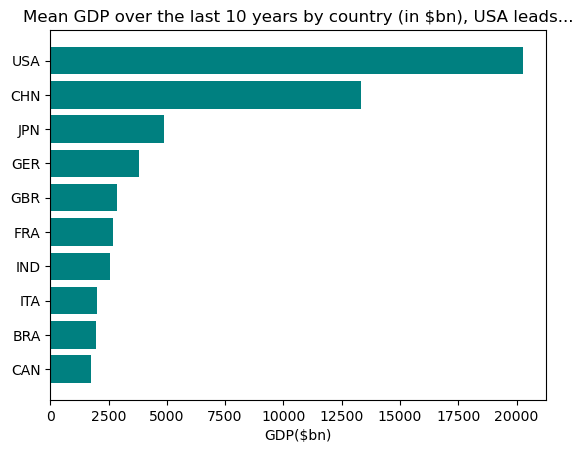

In [348]:
df_sorted = df_country2.sort_values(by='mean_gdp_last_10yr_bn', ascending=False)
top_10_values = df_sorted.head(10)

plt.barh(top_10_values['country_noc'], top_10_values['mean_gdp_last_10yr_bn'], color='teal')
plt.xlabel('GDP($bn)')
plt.title('Mean GDP over the last 10 years by country (in $bn), USA leads...')
plt.gca().invert_yaxis()
plt.show()

In [293]:
df_pop = pd.read_csv('data/raw/country_population.csv')
df_pop.drop(['Country Name',  'Indicator Name', 'Indicator Code'], axis=1, inplace=True)
df_pop.head()

,Country_Updated,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,59522.0,...,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0
1,Africa Eastern and Southern,AFE,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,153955516.0,158313235.0,...,567892149.0,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720839314.0
2,Afghanistan,AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,10010030.0,...,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0
3,Africa Western and Central,AFW,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,110798486.0,113319950.0,...,387204553.0,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0
4,Angola,AGO,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,5787044.0,5827503.0,...,26147002.0,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0


In [294]:
#df_pop.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)
df_pop2 = pd.merge(df_country, df_pop, how='left', left_on='country', right_on='Country_Updated')
df_pop2.head(3)

,country_noc,country,Country_Updated,Country Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,Afghanistan,Afghanistan,AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0
1,ALB,Albania,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,2837849.0,2811666.0,2775634.0
2,ALG,Algeria,Algeria,DZA,11394307.0,11598608.0,11778260.0,11969451.0,12179099.0,12381256.0,...,38000626.0,38760168.0,39543154.0,40339329.0,41136546.0,41927007.0,42705368.0,43451666.0,44177969.0,44903225.0


In [295]:
exclude_columns = ['country_noc', 'country', 'Country Code', 'Country_Updated']
df_pop2.loc[:, df_pop2.columns.difference(exclude_columns)] /= 1e6 # convert to millions 

In [296]:
#following a similar approach of taking the 10 year mean
df_pop2['mean_pop_last_10yr_mm'] = df_pop2.iloc[:, -10:].mean(axis=1)
df_country_pop = df_pop2[['country_noc', 'country', 'Country Code', 'mean_pop_last_10yr_mm']].copy()
df_country_pop.to_clipboard(index=False)

In [297]:
missing_values_pop = df_country_pop['mean_pop_last_10yr_mm'].isnull().sum()
missing_values_pop

51

We followed a similar approach for Population and calculated the 10yr mean as a proxy. Apart from China, USA, Russia, Japan, other countries with the highest mean population generally do not do well at the Games. Having a larger population could also mean less resources to invest in training athletes and could in fact, have a negative impact on medals won.

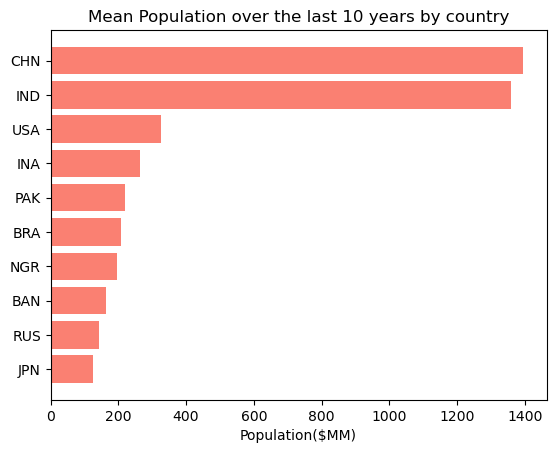

In [298]:
df_sorted_pop = df_country_pop.sort_values(by='mean_pop_last_10yr_mm', ascending=False)
top_10_values_pop = df_sorted_pop.head(10)


plt.barh(top_10_values_pop['country_noc'], top_10_values_pop['mean_pop_last_10yr_mm'], color='salmon')
plt.xlabel('Population($MM)')
plt.title('Mean Population over the last 10 years by country')
plt.gca().invert_yaxis()
plt.show()

In [344]:
#group by total medals for each country

df_grouped = df_medals.groupby('country_noc')['total'].sum()
df_grouped = pd.DataFrame(df_grouped)
df_grouped.reset_index(inplace=True)

In [349]:
#check correlation between variables and medals tally

df_merged = pd.merge(df_grouped, df_country2[['country_noc','mean_gdp_last_10yr_bn']
                                                                        ],how='left', on='country_noc')

df_merged2 = pd.merge(df_merged, df_country_pop[['country_noc','mean_pop_last_10yr_mm']
                                                                        ],how='left', on='country_noc')


df_merged2.head()


,country_noc,total,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm
0,AFG,2,18.897674,36.294729
1,AHO,1,NaN,NaN
2,ALG,17,176.800000,41.494506
3,ANZ,12,NaN,NaN
4,ARG,77,535.400000,44.249313


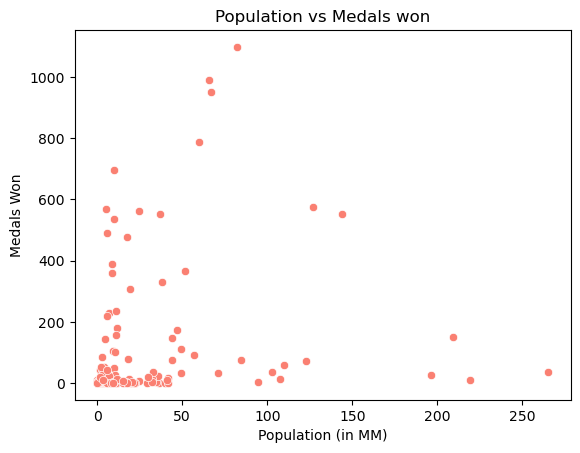

In [352]:
#exclude China, India, USA
excluded_countries = ['CHN', 'IND', 'USA']
df_filtered = df_merged2[~df_merged2['country_noc'].isin(excluded_countries)]
sns.scatterplot(y='total', x='mean_pop_last_10yr_mm', data=df_filtered, color='salmon')

# Add labels and title
plt.xlabel('Population (in MM)')
plt.ylabel('Medals Won')
plt.title('Population vs Medals won')

# Show the plot
plt.show()

We excluded China and USA along with India which has the second highest 10 yr mean population and it appears that some countries with smaller populations have won more medals. However, there are also countries that are very tiny, have very small populations and hence, have very low participation at the Olympics.

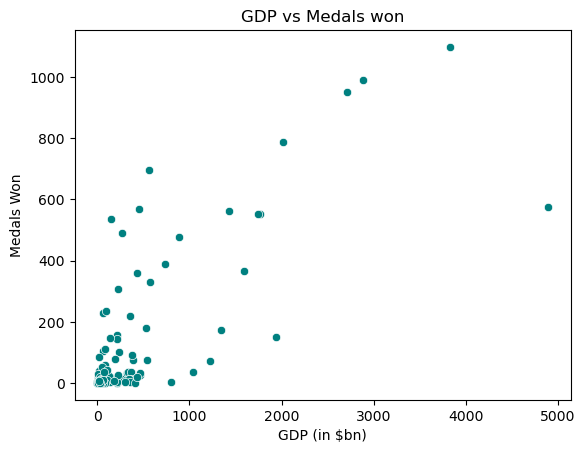

In [126]:
sns.scatterplot(y='total', x='mean_gdp_last_10yr_bn', data=df_filtered, color='teal')

# Add labels and title
plt.xlabel('GDP (in $bn)')
plt.ylabel('Medals Won')
plt.title('GDP vs Medals won')

# Show the plot
plt.show()

The scatter plot confirms that GDP is positvely correlated with medals one. We still have countries with missing GDP but they are either very small or nations that had a name change, we will be excluding those records.

In [353]:
# excluded_countries = ['USA']
# df_filtered = df_merged3[~df_merged3['country_noc'].isin(excluded_countries)]

# sns.scatterplot(y='total', x='total_athletes', data=df_filtered, color='mediumpurple')


# # Add labels and title
# plt.xlabel('Contingent Size')
# plt.ylabel('Medals Won')
# plt.title('Contingent Size vs Medals won')

# # Show the plot
# plt.show()

In [354]:
# join athletes with events to get the sport for each athlete, it is not in df_athletes

df_athletes_sport = pd.merge(df_athletes[['name', 'sex', 'height', 'weight']],
                              df_event_results[['athlete', 'sport']], left_on='name', right_on='athlete', how='left')

df_athletes_sport.head()

,name,sex,height,weight,athlete,sport
0,Károly Teppert,Male,na,na,Károly Teppert,Cycling Road
1,Károly Teppert,Male,na,na,Károly Teppert,Cycling Road
2,Andrzej Socharski,Male,173.0,72,Andrzej Socharski,Shooting
3,Nathalie Wunderlich,Female,170.0,50,Nathalie Wunderlich,Swimming
4,Nathalie Wunderlich,Female,170.0,50,Nathalie Wunderlich,Swimming


In [355]:
df_athletes_sport = df_athletes_sport.dropna()

In [356]:
df_athletes_sport['height'] = pd.to_numeric(df_athletes_sport['height'], errors='coerce')  
df_athletes_sport['weight'] = pd.to_numeric(df_athletes_sport['weight'], errors='coerce')  

# Group by 'sport' and calculate the average height and weight
average_data = df_athletes_sport.groupby(['sport', 'sex'])[['height', 'weight']].mean().reset_index()

#select a few sports 

select_sports = ['Archery', 'Artistic Gymnastics', 'Athletics',
                'Badminton', 'Boxing', 'Cross Country Skiing',
                'Cycling Track', 'Diving', 'Equestrian Dressage',
                'Fencing', 'Hockey', 'Judo',
                 'Rowing', 'Shooting', 'Handball',
                 'Swimming', 'Triathlon', 'Volleyball',
                 'Weightlifting', 'Wrestling', 'Basketball', 'Table Tennis', 'Tennis'
                ]

#keep only selected sports
mask = average_data['sport'].isin(select_sports) 
selected_df = average_data[mask]

<strong><i>How does an athlete’s height and weight affect their choice of sport?<strong><i>

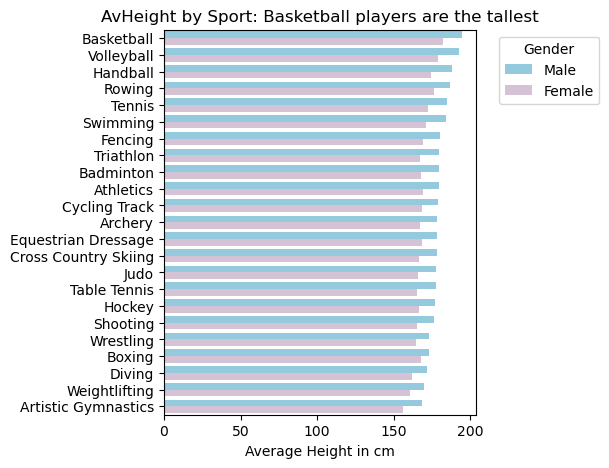

In [135]:
# Sort  in descending order
average_height_by_sport = selected_df.sort_values(by='height', ascending=False)
average_height_by_sport.dropna(inplace=True)

colors = {'Female': 'thistle', 'Male': 'skyblue'}

plt.figure(figsize=(5, 5))
sns.barplot(y='sport', x='height', hue='sex', data=average_height_by_sport, palette=colors)
plt.title('AvHeight by Sport: Basketball players are the tallest')
plt.xlabel('Average Height in cm')
plt.ylabel('')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.75)
plt.show()

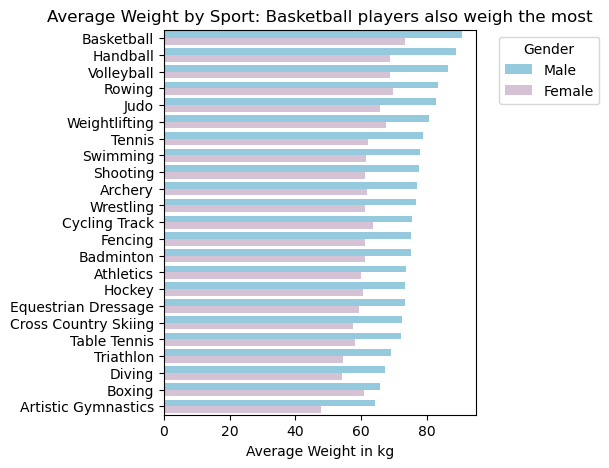

In [136]:
# Sort weight in descending order
average_weight_by_sport = selected_df.sort_values(by='weight', ascending=False)
average_weight_by_sport.dropna(inplace=True)

colors = {'Female': 'thistle', 'Male': 'skyblue'}

plt.figure(figsize=(5, 5))
sns.barplot(y='sport', x='weight', hue='sex', data=average_weight_by_sport, palette=colors)
plt.title('Average Weight by Sport: Basketball players also weigh the most')
plt.xlabel('Average Weight in kg')
plt.ylabel('')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.75)
plt.show()

We selected some of the most popular events at the Olympics to see if there is any obvious trend in the height and weight of athletes competing in those sports. The charts above show the average height and weight of all the athletes playing a particular sport, missing records were excluded. Basketball players tend to be the tallest and also weigh the most but the difference in the average height across sports is minimal for both males and females. On the other hand, the difference in weight between males and females across the different sports is more obvious. Furthermore, gymnasts, boxers and divers weigh less than athletes playing basketball or handball.

<strong><i>Which countries do better at team vs individual events?</i></strong>

In [137]:
#which countries do better at team vs individual events

df_event_results2 = df_event_results[df_event_results['medal'] != 'na']
df_event_results2.head()

,edition,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,pos,medal,isTeamSport
20,1908 Summer Olympics,5,ANZ,Athletics,"3,500 metres Race Walk, Men",56421,Harry Kerr,64719,3,Bronze,False
30,1908 Summer Olympics,5,ANZ,Boxing,"Middleweight, Men",21263,Snowy Baker,45153,2,Silver,False
32,1908 Summer Olympics,5,ANZ,Rugby,"Rugby, Men",31505,John Barnett,11237,1,Gold,True
33,1908 Summer Olympics,5,ANZ,Rugby,"Rugby, Men",31505,Phil Carmichael,11239,1,Gold,True
34,1908 Summer Olympics,5,ANZ,Rugby,"Rugby, Men",31505,Dan Carroll,11240,1,Gold,True


In [138]:
#group by country

df_team = df_event_results2.groupby(['country_noc', 'isTeamSport']).result_id.count().reset_index()
df_team = pd.DataFrame(df_team)
df_team

,country_noc,isTeamSport,result_id
0,AFG,False,2
1,AHO,False,1
2,ALG,False,17
3,ANZ,False,10
4,ANZ,True,35
...,...,...,...
231,YUG,False,52
232,YUG,True,362
233,ZAM,False,2
234,ZIM,False,7


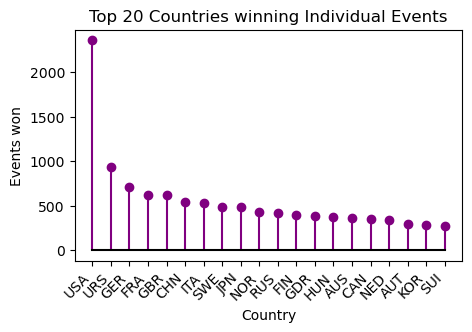

In [139]:
#filter by team vs individual
filtered_data = df_team[df_team['isTeamSport'] == False]

top_20_countries = filtered_data.groupby('country_noc')['result_id'].sum().nlargest(20).index

top_20_data = filtered_data[filtered_data['country_noc'].isin(top_20_countries)]

top_20_data = top_20_data.sort_values(by='result_id', ascending=False)

#lollipop chart
plt.figure(figsize=(5, 3))
plt.stem(top_20_data['country_noc'], top_20_data['result_id'], basefmt='k-', use_line_collection=True, markerfmt='purple',
         linefmt='purple')
plt.title('Top 20 Countries winning Individual Events')
plt.xlabel('Country')
plt.ylabel('Events won')
plt.xticks(rotation=45, ha='right')


plt.show()

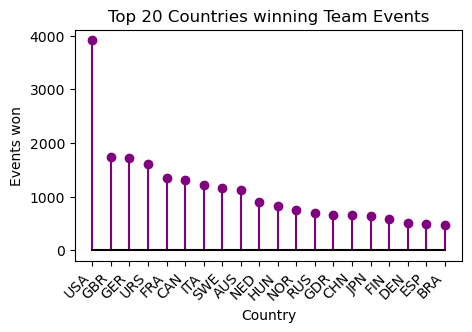

In [140]:
filtered_data2 = df_team[df_team['isTeamSport'] == True]

top_20_countries2 = filtered_data2.groupby('country_noc')['result_id'].sum().nlargest(20).index


top_20_data2 = filtered_data2[filtered_data2['country_noc'].isin(top_20_countries2)]

# Sort the data for better visualization
top_20_data2 = top_20_data2.sort_values(by='result_id', ascending=False)

# Create a lollipop chart
plt.figure(figsize=(5,3))
plt.stem(top_20_data2['country_noc'], top_20_data2['result_id'], basefmt='k-', use_line_collection=True, markerfmt='purple',
         linefmt='purple')
plt.title('Top 20 Countries winning Team Events')
plt.xlabel('Country')
plt.ylabel('Events won')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

While the USA is an outlier doing well at both individual and team events, Great Britain comes next in terms of most medals won at team events. Countries like Canada, Australia, the Netherlands among others also happen to do better at team events than individual events.

<strong><i>Who is the greatest Olympian of all time?<strong><i>

In [144]:
#greatest Olympian of all time 

greatest_olympian = df_event_results2.groupby(['athlete', 'sport', 'country_noc']).result_id.count().sort_values(ascending=False)
greatest_olympian = pd.DataFrame(greatest_olympian)
greatest_olympian.rename({'result_id':'medals_won'}, axis=1, inplace=True)
greatest_olympian.reset_index(inplace=True)
greatest_olympian.head()

,athlete,sport,country_noc,medals_won
0,Michael Phelps,Swimming,USA,28
1,Larisa Latynina,Artistic Gymnastics,URS,18
2,Marit Bjørgen,Cross Country Skiing,NOR,15
3,Nikolay Andrianov,Artistic Gymnastics,URS,15
4,Ireen Wüst,Speed Skating,NED,13


In [147]:
greatest_olympian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32361 entries, 0 to 32360
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   athlete      32361 non-null  object
 1   sport        32361 non-null  object
 2   country_noc  32361 non-null  object
 3   medals_won   32361 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1011.4+ KB


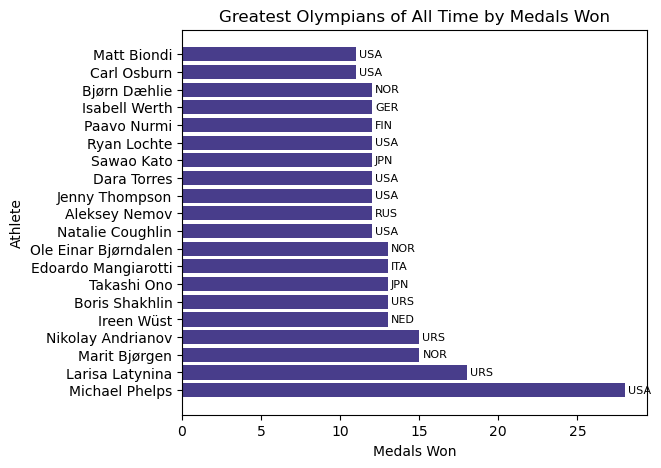

In [149]:
greatest_olympian2 = greatest_olympian.sort_values(by='medals_won', ascending=False)
greatest_olympian2 = greatest_olympian2.head(20)
plt.figure(figsize=(6, 5))
bars = plt.barh(greatest_olympian2['athlete'], greatest_olympian2['medals_won'], color='darkslateblue')
plt.xlabel('Medals Won')
plt.ylabel('Athlete')
plt.title('Greatest Olympians of All Time by Medals Won')

for bar, label in zip(bars, greatest_olympian2['country_noc']):
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2, label, ha='left', va='center', color='black', fontsize=8)

plt.show()

Michael Phelps is well-known as the greatest Olympian of all time but in second place is Larisa Latynina, a gymnast from the former Soviet Union who won 18 medals. 25% of the top 20 are from the USA.

<strong><i>Which gender wins more medals? </strong></i>

In [150]:
#which gender wins more medals
gender_medals = pd.merge(df_athletes[['name', 'sex']], df_event_results2[['athlete','medal', 'sport','result_id']],
                        left_on="name", right_on="athlete")
gender_medals2 = gender_medals.groupby('sex').athlete.count()
gender_medals2=pd.DataFrame(gender_medals2)
gender_medals2.reset_index(inplace=True)

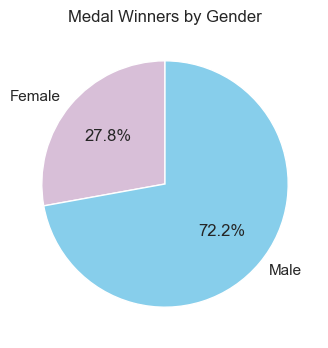

In [151]:
plt.figure(figsize=(4, 4))
sns.set(style="whitegrid")
plt.pie(gender_medals2['athlete'], labels=gender_medals2.sex, autopct='%1.1f%%', startangle=90,
        colors=['thistle', 'skyblue'])


plt.title('Medal Winners by Gender')

plt.show()


In [152]:
#gold medal winners

gender_gold = gender_medals[gender_medals['medal'] == 'Gold']

gender_gold2 = gender_gold.groupby('sex').athlete.count()
gender_gold2=pd.DataFrame(gender_gold2)
gender_gold2.reset_index(inplace=True)
gender_gold2

,sex,athlete
0,Female,4248
1,Male,11253


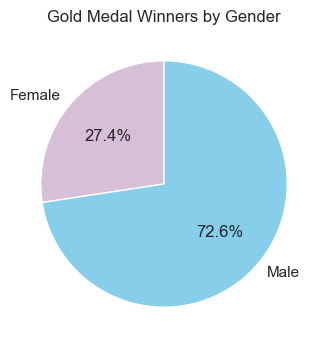

In [153]:
plt.figure(figsize=(4, 4))
sns.set(style="whitegrid")
plt.pie(gender_gold2['athlete'], labels=gender_gold2.sex, autopct='%1.1f%%', startangle=90,
        colors=['thistle', 'skyblue'])


plt.title('Gold Medal Winners by Gender')

plt.show()


72% of all medal winners are Male, with a similar stat for gold medal winners. This is expected given that the historical participation rate of female athletes  is 26%.

In [154]:
gender_all = df_athletes.groupby('sex')['name'].count()
gender_all

sex
Female     40276
Male      114755
Name: name, dtype: int64

In [111]:
# how many athletes take part by country
df_event_results.groupby(['edition', 'country_noc'], as_index=False)['athlete'].count().head()

,edition,country_noc,athlete
0,1896 Summer Olympics,AUS,7
1,1896 Summer Olympics,AUT,10
2,1896 Summer Olympics,BUL,4
3,1896 Summer Olympics,DEN,25
4,1896 Summer Olympics,FRA,51


In [112]:
# one athlete can take part in several events
df_event_results.groupby(['edition', 'country_noc'])['athlete'].unique().reset_index(name='unique_athletes').assign(athlete_count=lambda x: x['unique_athletes'].apply(len)).head()


,edition,country_noc,unique_athletes,athlete_count
0,1896 Summer Olympics,AUS,"[Teddy Flack, George Stuart Robertson]",2
1,1896 Summer Olympics,AUT,"[Adolf Schmal, Otto Herschmann, Paul Neumann]",3
2,1896 Summer Olympics,BUL,[Charles Champaud],1
3,1896 Summer Olympics,DEN,"[Viggo Jensen, Eugen Schmidt, Holger Nielsen, ...",4
4,1896 Summer Olympics,FRA,"[Adolphe Grisel, Jean Tournois, Louis Adler, A...",18


Merge: Join medals and games

In [357]:
# df_medals['edition_id'].nunique()
# df_games['edition_id'].nunique()


# drop war and future events
df_games = df_games.drop(df_games[~df_games['edition_id'].isin(df_medals['edition_id'])].index)


df_games_medals = pd.merge(df_medals, pd.merge(df_games, df_country, on='country_noc', how='left'), on=['edition_id', 'edition', 'year'], how='left',
        suffixes=('_performing', '_host'))
df_games_medals.head()

,edition,edition_id,year,country_performing,country_noc_performing,gold,silver,bronze,total,edition_url,city,country_flag_url,country_noc_host,start_date,end_date,competition_date,isHeld,country_host
0,1896 Summer Olympics,1,1896,United States,USA,11,7,2,20,/editions/1,Athina,/images/flags/GRE.png,GRE,6 April,15 April,6 – 13 April,NaN,Greece
1,1896 Summer Olympics,1,1896,Greece,GRE,10,18,19,47,/editions/1,Athina,/images/flags/GRE.png,GRE,6 April,15 April,6 – 13 April,NaN,Greece
2,1896 Summer Olympics,1,1896,Germany,GER,6,5,2,13,/editions/1,Athina,/images/flags/GRE.png,GRE,6 April,15 April,6 – 13 April,NaN,Greece
3,1896 Summer Olympics,1,1896,France,FRA,5,4,2,11,/editions/1,Athina,/images/flags/GRE.png,GRE,6 April,15 April,6 – 13 April,NaN,Greece
4,1896 Summer Olympics,1,1896,Great Britain,GBR,2,3,2,7,/editions/1,Athina,/images/flags/GRE.png,GRE,6 April,15 April,6 – 13 April,NaN,Greece


In [358]:
#special or one time events
df_games_medals[(df_games_medals['edition_id'] == 4)|(df_games_medals['edition_id'] == 48)]

# drop the one-time events
df_games_medals = df_games_medals.drop(df_games_medals[(df_games_medals['edition_id'] == 4)|
                                                       (df_games_medals['edition_id'] == 48)].index)

In [359]:
df_games_medals.describe()

,edition_id,year,gold,silver,bronze,total
count,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000
mean,31.850168,1980.582492,3.743547,3.727834,3.981481,11.452862
std,18.362667,32.065060,7.587106,6.441069,6.194507,19.511691
min,1.000000,1896.000000,0.000000,0.000000,0.000000,1.000000
25%,17.000000,1960.000000,0.000000,1.000000,1.000000,2.000000
50%,25.000000,1988.000000,1.000000,2.000000,2.000000,5.000000
75%,53.000000,2008.000000,4.000000,4.000000,5.000000,13.000000
max,62.000000,2022.000000,83.000000,85.000000,83.000000,248.000000


In [362]:
#some more eda

def eda_visualization(df):
    numerical_columns = df.select_dtypes(include='number').columns
    categorical_columns = df.select_dtypes(exclude='number').columns

    for column in numerical_columns:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
        
        plt.subplot(1, 2, 2)
        ax = sns.boxplot(data=df, x=column, showfliers=False)
        plt.title(f'Boxplot of {column} Without Outliers')
        
        def add_quartile_labels(ax):
            for line in ax.lines:
                x, y = line.get_xydata()[0]  
                ax.text(x, y, f"{x:.0f}", ha='left', va='center')
        
        add_quartile_labels(ax)

        plt.tight_layout()
        plt.show()

    for column in categorical_columns:
        plt.figure(figsize=(8, 4))
        categories_to_show = df[column].value_counts().index[:30]

        if not categories_to_show.empty:
            sns.countplot(data=df[df[column].isin(categories_to_show)], x=column, order=categories_to_show)

            for idx, count in enumerate(df[df[column].isin(categories_to_show)][column].value_counts()):
                plt.text(idx, count + 1, str(count), ha='center', va='bottom', fontsize=8)

            plt.title(f'Count of each category in {column}')
            plt.xticks(rotation=90, ha='right', fontsize=7)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No categories to show for column {column}.")

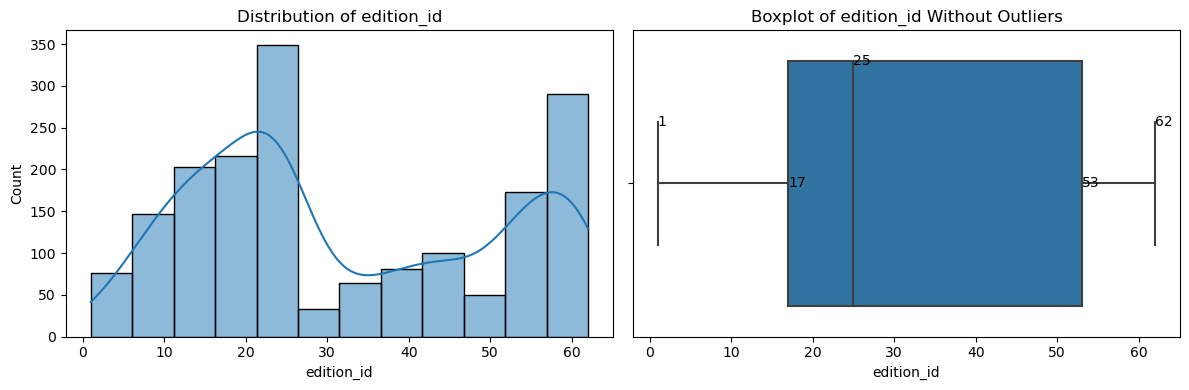

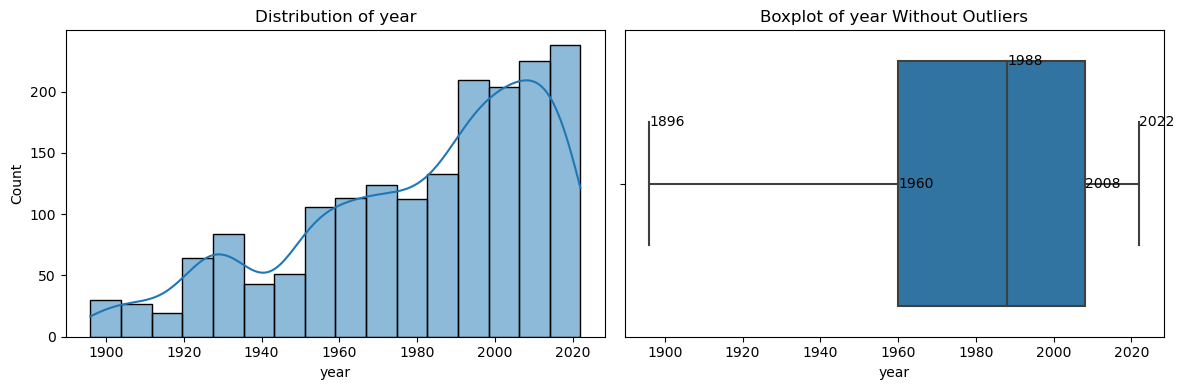

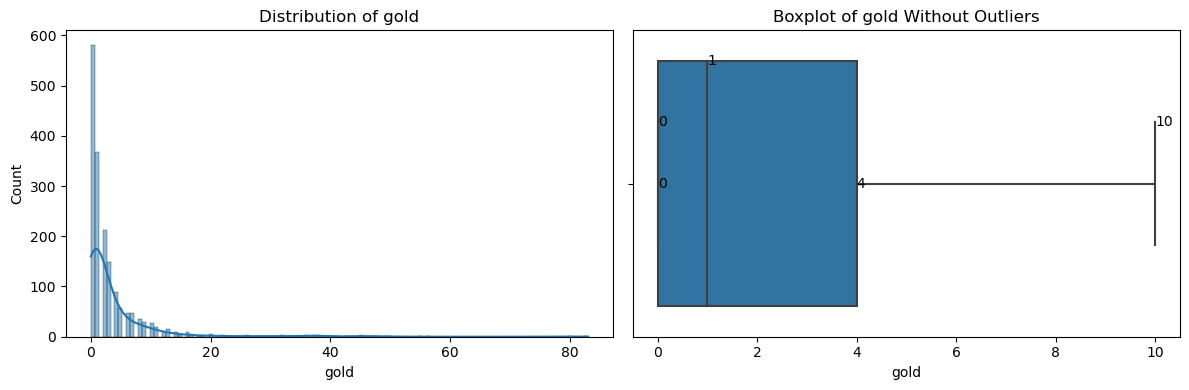

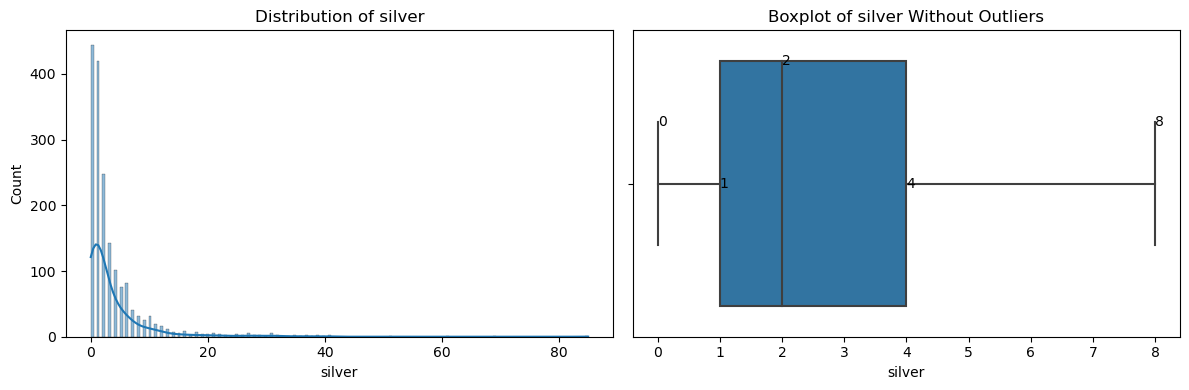

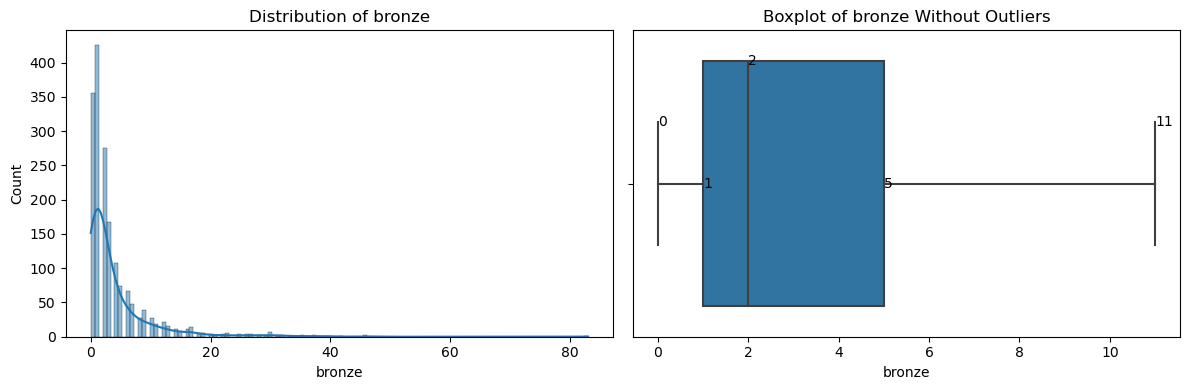

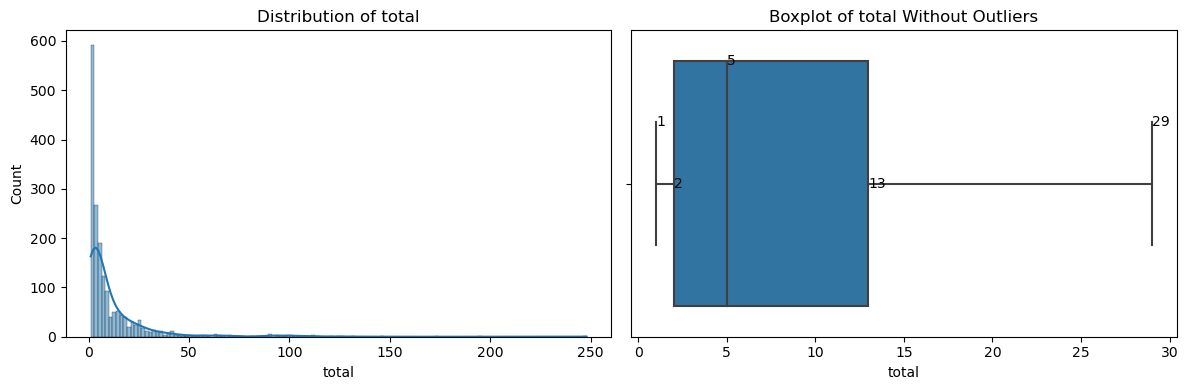

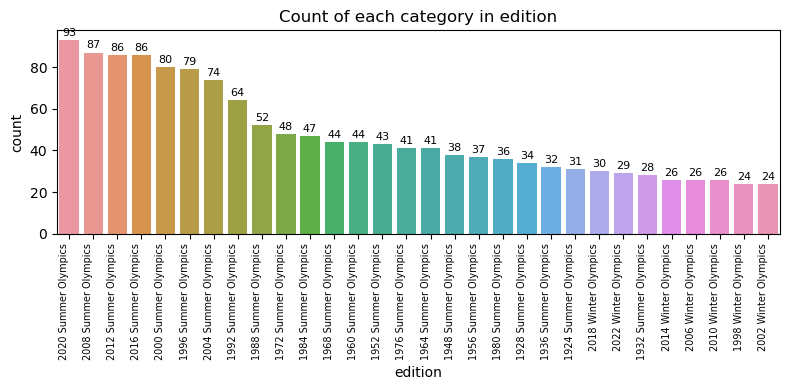

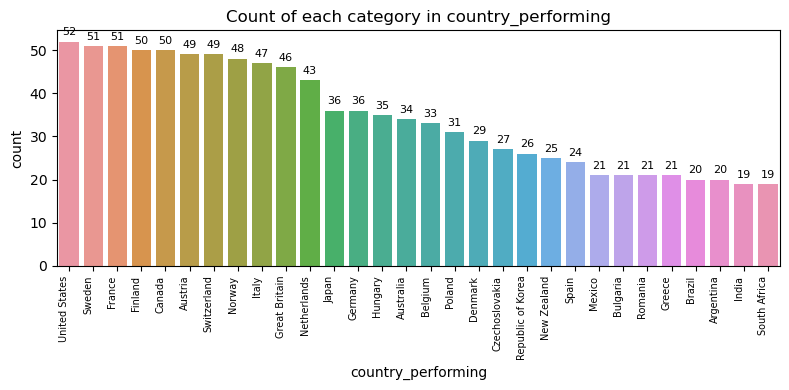

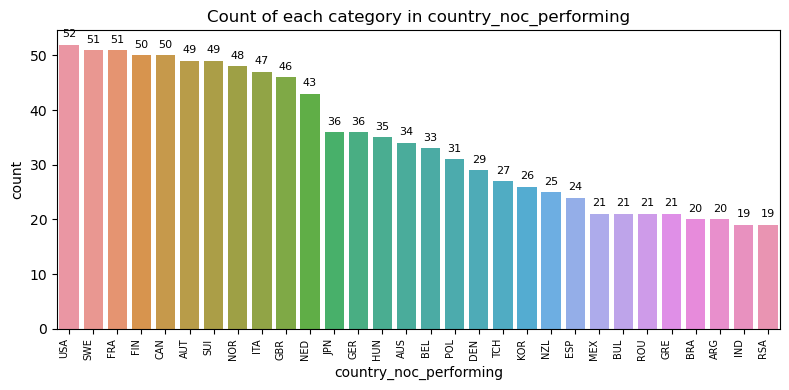

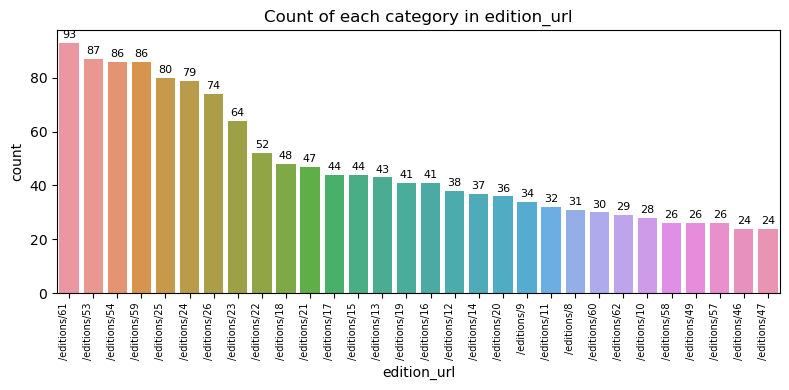

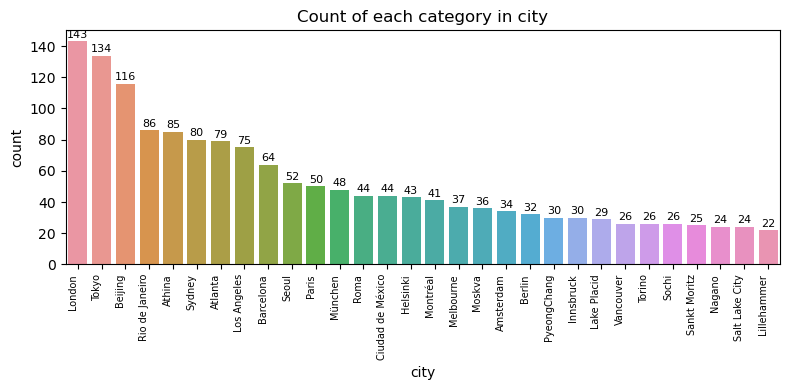

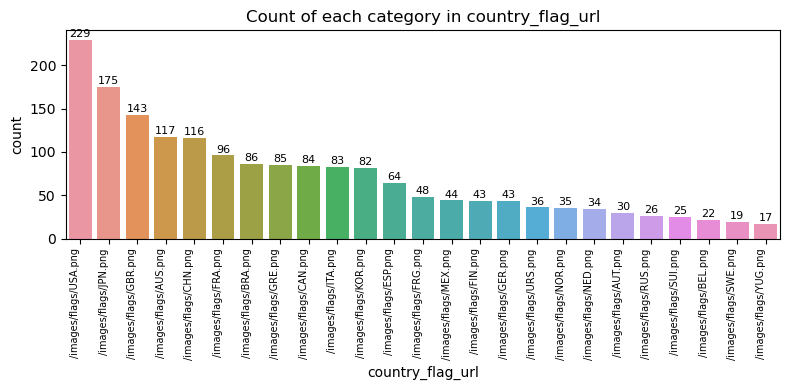

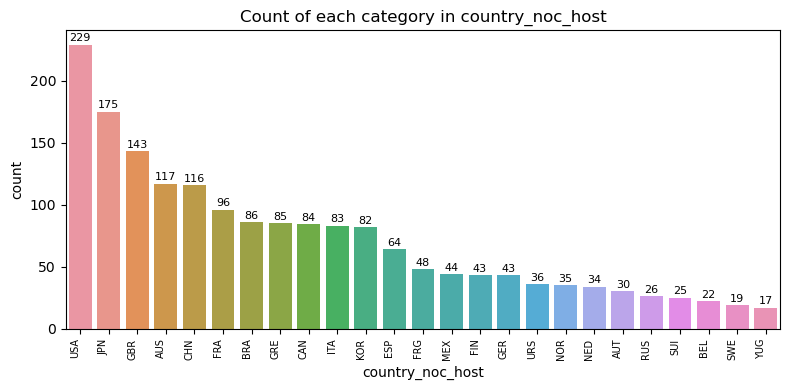

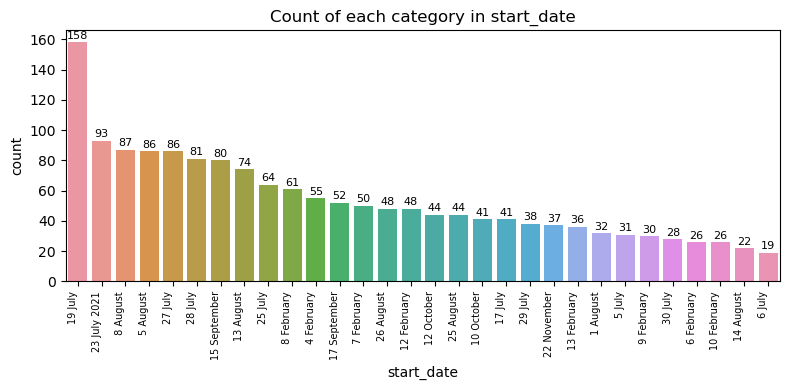

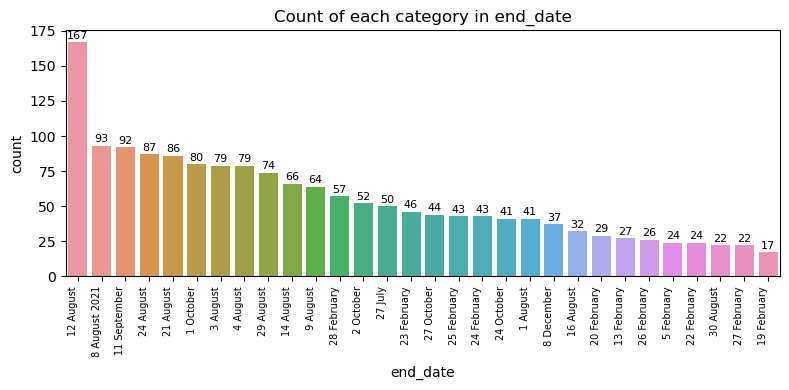

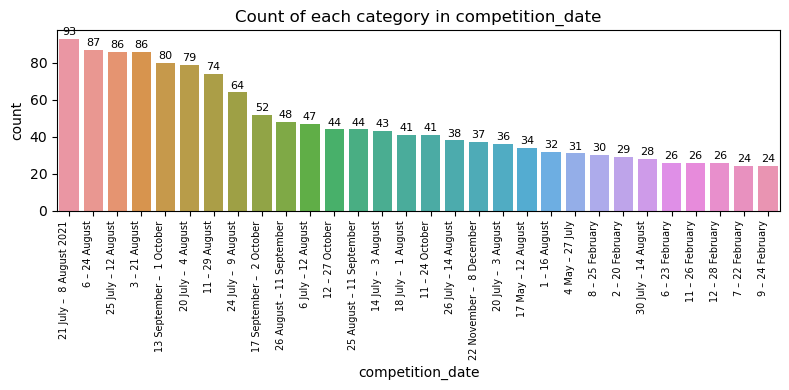

No categories to show for column isHeld.


<Figure size 800x400 with 0 Axes>

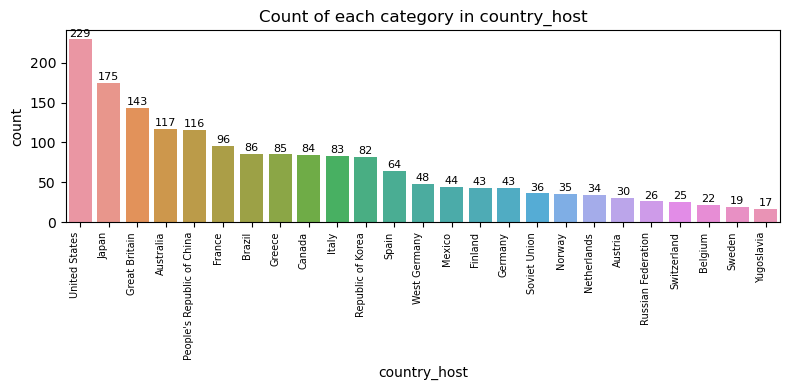

In [363]:
eda_visualization(df_games_medals)

In [7]:
#further analyze df_games_medals 
df_comparison = df_games_medals.groupby(['country_host', 'edition', 'year', 'country_performing'], as_index=False)[['total', 'gold', 'silver', 'bronze']].sum() \
    .groupby('edition', group_keys=False) \
    .apply(lambda x: x.nlargest(8,'total'))

In [8]:
df_comparison.head()

,country_host,edition,year,country_performing,total,gold,silver,bronze
670,Greece,1896 Summer Olympics,1896,Greece,47,10,18,19
674,Greece,1896 Summer Olympics,1896,United States,20,11,7,2
668,Greece,1896 Summer Olympics,1896,Germany,13,6,5,2
667,Greece,1896 Summer Olympics,1896,France,11,5,4,2
669,Greece,1896 Summer Olympics,1896,Great Britain,7,2,3,2


In [161]:
#add dummy variabe for season
df_comparison['season'] = [1 if 'Winter' in edition else 0 for edition in df_comparison['edition']]

In [162]:
#add another dummy variable for is_host

df_comparison['is_host'] = np.where(df_comparison['country_host'] == df_comparison['country_performing'], 1, 0)

In [ ]:
# # does it look like being host country gives a medal advantage?
# color_map = {'red': 'red', 0: 'black'}
# for i in range(0,2):
#     fig = px.bar(df_comparison[df_comparison['season']==i], x='year', y='total',
#                  hover_data=['country_performing', 'country_host'],
#                  title=f'Total Number of Medals Won by Country per Year, Season = {i}',
#                  text=df_comparison[df_comparison['season']==i].apply(lambda row: row['country_host'] if row['country_host'] == row['country_performing'] else None, axis=1),
#                  color=df_comparison[df_comparison['season']==i].apply(lambda row: 'red' if row['country_host'] == row['country_performing'] else 0, axis=1),
#                  color_discrete_map=color_map)


#     fig.update_layout(showlegend=False, height=750, width=1070,
#                       xaxis_title='Year',
#                       yaxis_title='Total Medals by Country')
    
#     legend_annotation = "Color Legend:<br>Red = Host Country<br>Black = Other Country"
#     fig.add_annotation(
#         text=legend_annotation,
#         xref="paper", yref="paper",
#         x=0.02, y=0.9,
#         showarrow=False,
#         font=dict(size=12),
#         bgcolor="lightgrey",
#         bordercolor="black",
#         borderwidth=1
#     )



#     fig.show()
#     #pio.write_html(fig, file=f'graphs/host_advantage{i}.html', auto_open=True)

# # these graphs are available at:
# # https://sandra-forro.github.io/figures_olymploration/host_advantage0.html
# # https://sandra-forro.github.io/figures_olymploration/host_advantage1.html

In [163]:
df_summer = df_comparison[df_comparison['season'] == 0]
df_summer2 = df_summer.groupby(['year', 'is_host'])['total'].sum()
df_summer2 = pd.DataFrame(df_summer2)
df_summer2.reset_index(inplace=True)
df_summer2.head()

,year,is_host,total
0,1896,0,68
1,1896,1,47
2,1900,0,135
3,1900,1,111
4,1904,0,32


<strong><i>Does being a host country appear to furnish an advantage?</i></strong>
<br>
For most years, the host country wins medals. The number of medals won by the host country appears to be more sizable during the summer games than the winter ones. Though some countries are repeatedly hosting the games and could simply be strong contenders, it is likely still an influential factor. We will include is_host and season as two binary variables to capture this potential effect. 


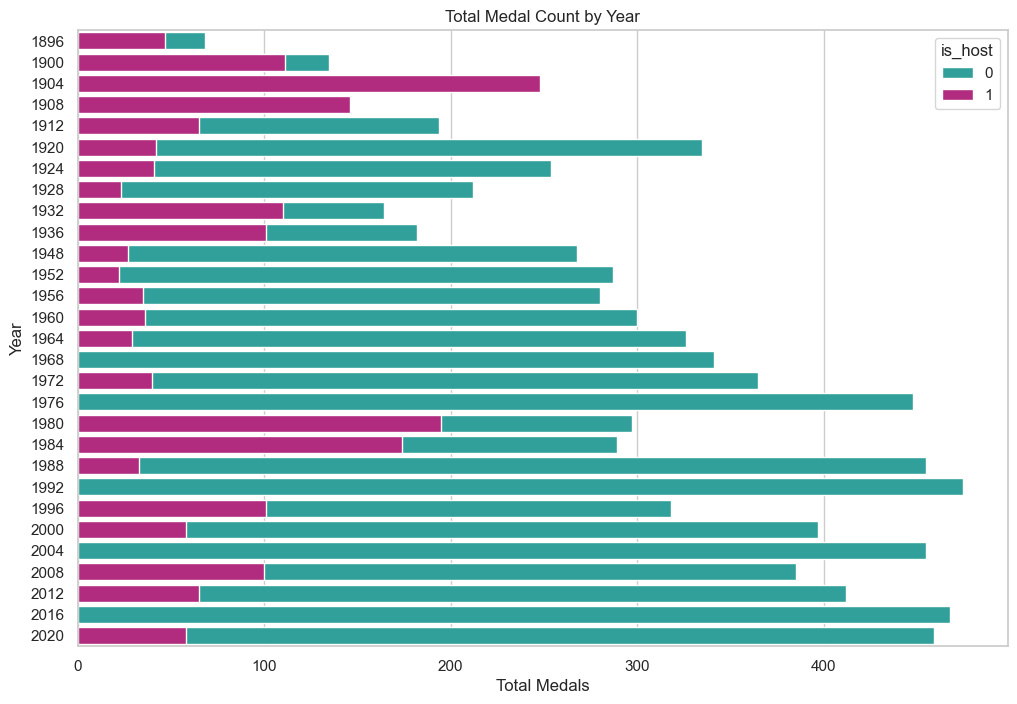

In [164]:
#plot summer games
plt.figure(figsize=(12, 8))
sns.barplot(x='total', y='year', hue='is_host', data=df_summer2, dodge=False, ci=None,palette={1: 'mediumvioletred', 0: 'lightseagreen'}, orient='h')
plt.title('Total Medal Count by Year')
plt.xlabel('Total Medals')
plt.ylabel('Year')
plt.show()

In [165]:
#plot winter games

df_winter = df_comparison[df_comparison['season'] == 1]
df_winter2 = df_winter.groupby(['year', 'is_host'])['total'].sum()
df_winter2 = pd.DataFrame(df_winter2)
df_winter2.reset_index(inplace=True)
df_winter2.head()

,year,is_host,total
0,1924,0,44
1,1924,1,3
2,1928,0,37
3,1932,0,28
4,1932,1,12


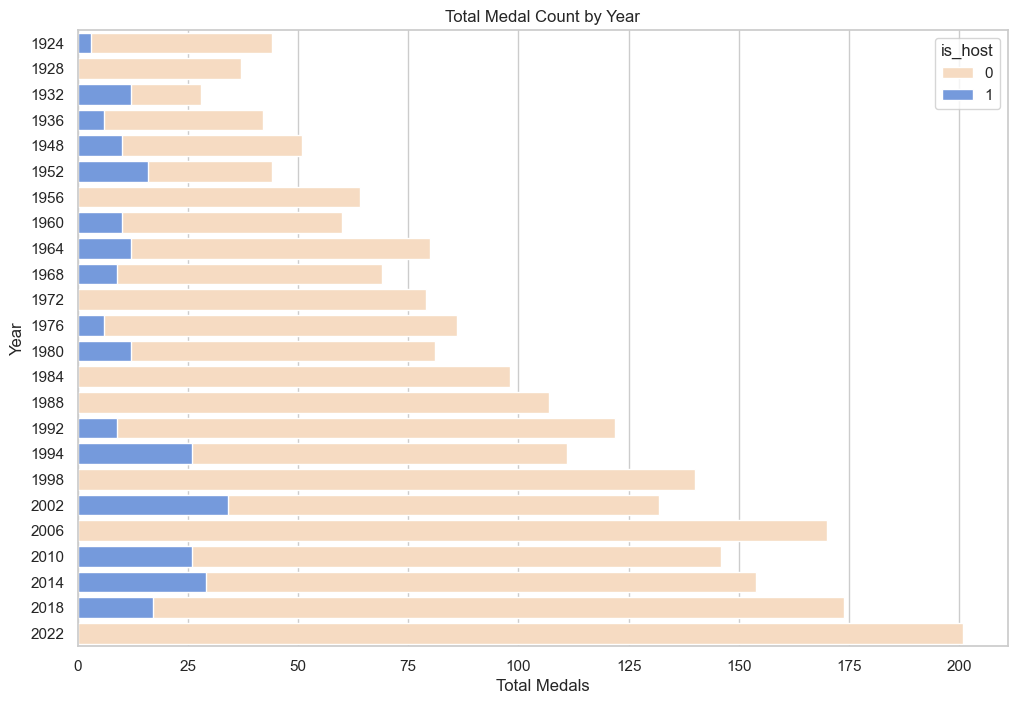

In [166]:

plt.figure(figsize=(12, 8))
sns.barplot(x='total', y='year', hue='is_host', data=df_winter2, dodge=False, ci=None,palette={1: 'cornflowerblue', 0: 'peachpuff'}, orient='h')
plt.title('Total Medal Count by Year')
plt.xlabel('Total Medals')
plt.ylabel('Year')
plt.show()

In [168]:
#lets explore the summer games by excluding usa 

df_summer_nousa = df_comparison[(df_comparison['season'] == 0) & (df_comparison['country_performing'] != 'United States')]
df_summer_nousa2 = df_summer_nousa.groupby(['year', 'is_host'])['total'].sum()
df_summer_nousa2= pd.DataFrame(df_summer_nousa2)
df_summer_nousa2.reset_index(inplace=True)
df_summer_nousa2.head()

,year,is_host,total
0,1896,0,48
1,1896,1,47
2,1900,0,87
3,1900,1,111
4,1904,0,32


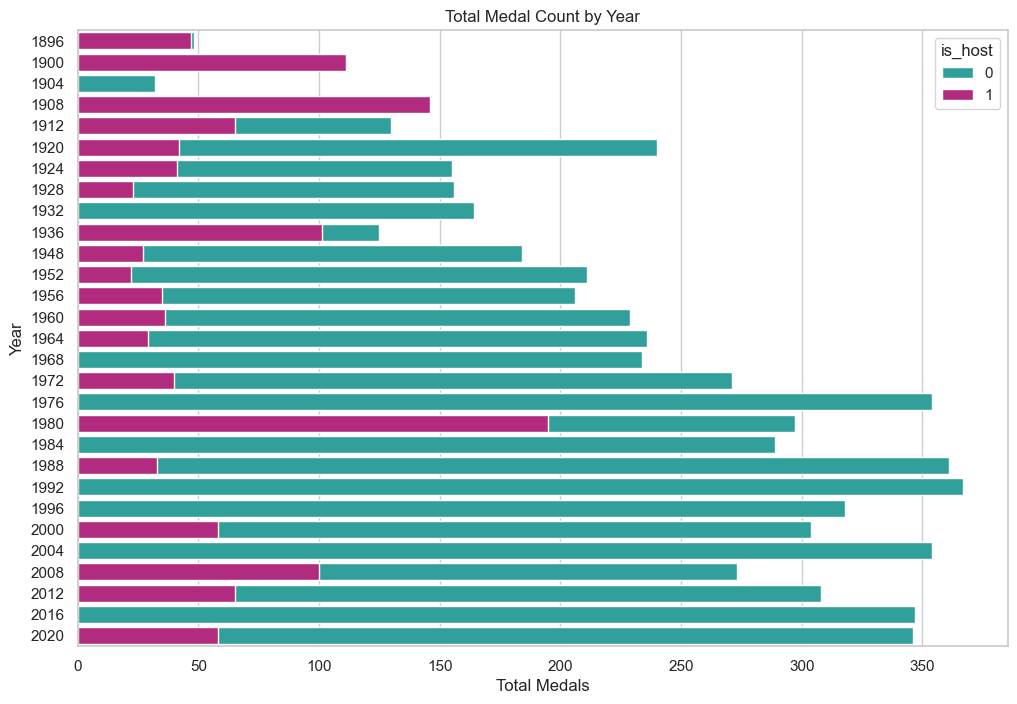

In [169]:
plt.figure(figsize=(12, 8))
sns.barplot(x='total', y='year', hue='is_host', data=df_summer_nousa2, dodge=False, ci=None,palette={1: 'mediumvioletred', 0: 'lightseagreen'}, orient='h')
plt.title('Total Medal Count by Year')
plt.xlabel('Total Medals')
plt.ylabel('Year')
plt.show()

<strong> Start building model:</strong>

In [445]:
#Building a baseline model

#Model 1: Using data for the 2020 Olympics only

#start building df to predict medal count at the 2024 summer games

#feel free to change any of this, remove or add other variables.etc., haven't scaled or anything, this was just to test

df_games_medals['is_host'] = np.where(df_games_medals['country_host'] == df_games_medals['country_performing'], 1, 0)

#add gdp and population-using already processed df saved in the data folder

df_gdp_pop = pd.merge(df_gdp_mean,df_pop_mean, on='country_noc', how='left')
df_gdp_pop.drop(['country_x', 'Country Code_x', 'country_y', 'Country Code_y'], axis=1, inplace=True)

In [446]:
#cols for model
df_cols = df_games_medals[['year','edition', 'country_noc_performing', 'gold', 'silver', 'bronze','total', 'is_host']]

In [447]:
df_cols.rename({'country_noc_performing':'country_noc'}, axis=1, inplace=True)
df_cols.head()

,year,edition,country_noc,gold,silver,bronze,total,is_host
0,1896,1896 Summer Olympics,USA,11,7,2,20,0
1,1896,1896 Summer Olympics,GRE,10,18,19,47,1
2,1896,1896 Summer Olympics,GER,6,5,2,13,0
3,1896,1896 Summer Olympics,FRA,5,4,2,11,0
4,1896,1896 Summer Olympics,GBR,2,3,2,7,0


In [448]:
#merge
df_model = pd.merge(df_cols, df_gdp_pop[['country_noc','mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm']], on='country_noc', how='left')


In [449]:
#add contingent size 
contingent_size = df_event_results.groupby(['edition', 'country_noc'], as_index=False)['athlete'].nunique()

df_model2 = pd.merge(df_model, contingent_size[['edition','country_noc','athlete']], on=['edition','country_noc'], how='left')
df_model2.head()

,year,edition,country_noc,gold,silver,bronze,total,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,athlete
0,1896,1896 Summer Olympics,USA,11,7,2,20,0,20260.0,325.537793,22.0
1,1896,1896 Summer Olympics,GRE,10,18,19,47,1,210.3,10.756997,138.0
2,1896,1896 Summer Olympics,GER,6,5,2,13,0,3822.0,82.475589,20.0
3,1896,1896 Summer Olympics,FRA,5,4,2,11,0,2708.0,67.030750,18.0
4,1896,1896 Summer Olympics,GBR,2,3,2,7,0,2880.0,65.989286,15.0


In [450]:
df_model2.rename({'athlete':'contingent_size'}, axis=1,inplace=True)

In [451]:
#number of events they participate in

event_participation =  df_event_results.groupby(['edition', 'country_noc'], 
                                                                 as_index=False)['event'].nunique()

df_model3 = pd.merge(df_model2, event_participation[['edition','country_noc','event']], on=['edition','country_noc'], how='left')
df_model3.rename({'event':'event_count'}, axis=1, inplace=True)
df_model3.head()

,year,edition,country_noc,gold,silver,bronze,total,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,contingent_size,event_count
0,1896,1896 Summer Olympics,USA,11,7,2,20,0,20260.0,325.537793,22.0,20.0
1,1896,1896 Summer Olympics,GRE,10,18,19,47,1,210.3,10.756997,138.0,40.0
2,1896,1896 Summer Olympics,GER,6,5,2,13,0,3822.0,82.475589,20.0,30.0
3,1896,1896 Summer Olympics,FRA,5,4,2,11,0,2708.0,67.030750,18.0,26.0
4,1896,1896 Summer Olympics,GBR,2,3,2,7,0,2880.0,65.989286,15.0,24.0


In [452]:
#has country won medals in the past

prior_medals = pd.DataFrame(df_medals.groupby('country_noc')['total'].sum())
prior_medals.reset_index(inplace=True)
prior_medals.head()

,country_noc,total
0,AFG,2
1,AHO,1
2,ALG,17
3,ANZ,12
4,ARG,77


In [453]:
#add dummy
prior_medals['prior_medals'] = (prior_medals['total'] > 0).astype(int)

In [454]:
#using 2020 data only
df_2020 = df_model3.loc[df_model3['year']==2020]

In [455]:
df_2020.drop(['year', 'edition', 'gold', 'silver', 'bronze'], axis=1, inplace=True)

In [456]:
#add medals in prior games 

df_medals_2016= df_medals.loc[df_medals['year']==2016]
df_medals_2016.rename({'total':'2016_medals'}, axis=1, inplace=True)

In [457]:
#merge
df_2020_base = pd.merge(df_2020, df_medals_2016[['country_noc', '2016_medals']], how ='left', on=['country_noc'])
df_2020_base.head()

,country_noc,total,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,contingent_size,event_count,2016_medals
0,USA,113,0,20260.0,325.537793,628.0,244.0,121.0
1,CHN,88,0,13337.0,1394.510500,415.0,199.0,70.0
2,JPN,58,1,4893.0,126.642158,609.0,222.0,41.0
3,GBR,64,0,2880.0,65.989286,390.0,188.0,67.0
4,ROC,71,0,NaN,NaN,336.0,199.0,NaN


In [458]:
df_2020_base['2016_medals'].fillna(0, inplace=True)

In [459]:
df_2020_base.dropna(inplace=True)

In [460]:
df_2020_base.rename({'total':'total_medals'}, axis=1, inplace=True)

In [461]:
df_2020_base = pd.merge(df_2020_base, prior_medals[['country_noc', 'prior_medals']], 
                        on='country_noc', how='left')

In [462]:
#run a basic linear reg model
X = df_2020_base[['is_host', 'mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm', 'contingent_size',
            'event_count', '2016_medals', 'prior_medals']]
y = df_2020_base['total_medals']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.25, random_state=101) 

In [463]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

In [464]:
mse_test = mean_squared_error(y_test, base_predictions)
print(mse_test)

42.5140090148492


In [465]:
base_train_predictions = base_model.predict(X_train)
mse_train = mean_squared_error(y_train, base_train_predictions)
print(mse_train)

44.59628342712415


In [466]:
#add predictions to df 
df_2020_base['predicted_total_medals'] = base_model.predict(X)
df_2020_base.head()

,country_noc,total_medals,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,contingent_size,event_count,2016_medals,prior_medals,predicted_total_medals
0,USA,113,0,20260.0,325.537793,628.0,244.0,121.0,1,111.765676
1,CHN,88,0,13337.0,1394.510500,415.0,199.0,70.0,1,69.380826
2,JPN,58,1,4893.0,126.642158,609.0,222.0,41.0,1,56.672647
3,GBR,64,0,2880.0,65.989286,390.0,188.0,67.0,1,45.326512
4,ROC,71,0,1489.0,144.100000,336.0,199.0,0.0,1,34.903452


In [467]:
coefficients = base_model.coef_

# coefficients with their corresponding feature names
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

print(coef_df)

                 Feature  Coefficient
0                is_host     0.000000
1  mean_gdp_last_10yr_bn     0.002933
2  mean_pop_last_10yr_mm    -0.006703
3        contingent_size     0.015718
4            event_count     0.145833
5            2016_medals     0.098139
6           prior_medals     0.000000


In [469]:
#Model 2- exlcuding USA, just testing if there is any improvement


df_2020_wo_usa = df_2020_base.loc[df_2020_base['country_noc']!= 'USA']

X = df_2020_wo_usa[['is_host', 'mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm', 'contingent_size',
            'event_count', '2016_medals', 'prior_medals']]
y = df_2020_wo_usa['total_medals']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.25, random_state=101) 

In [470]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

In [471]:
mse_test = mean_squared_error(y_test, base_predictions)
print(mse_test)

40.4681739261962


In [472]:
base_train_predictions = base_model.predict(X_train)
mse_train = mean_squared_error(y_train, base_train_predictions)
print(mse_train)

45.78064805217699


In [473]:
coefficients = base_model.coef_

# coefficients with their corresponding feature names
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

print(coef_df)

                 Feature  Coefficient
0                is_host     0.000000
1  mean_gdp_last_10yr_bn     0.005369
2  mean_pop_last_10yr_mm    -0.009098
3        contingent_size    -0.000467
4            event_count     0.171965
5            2016_medals    -0.098480
6           prior_medals     0.000000
